In [34]:
import os
import xarray as xr
import numpy as np
import cftime
import matplotlib.pyplot as plt

from osprey.means.eof import preproc_pattern_3D, preproc_timeseries_3D
from osprey.actions.reader import elements
from osprey.utils.folders import folders
from osprey.means.means import timemean
from osprey.utils.time import get_startleg, get_year
from osprey.utils import run_cdo

In [20]:
expname = "FE00"
var = "thetao"
ndim ="3D"
endleg = 11
yearspan = 10
yearleap = 10
startleg = get_startleg(endleg, yearspan)
startyear = get_year(startleg)
endyear = get_year(endleg)
window = endyear - startyear + 1
dirs = folders(expname)

In [24]:
run_cdo.merge(expname, startyear, endyear)
run_cdo.selname(expname, var, endleg)
run_cdo.detrend(expname, var, endleg)
run_cdo.get_EOF(expname, var, endleg, window)

File /ec/res4/scratch/itas/martini/FE00/011/data.nc successfully removed.
Command: 'cdo cat /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1990-1990.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1991-1991.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1992-1992.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1993-1993.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1994-1994.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1995-1995.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1996-1996.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1997-1997.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1998-1998.nc /ec/res4/scratch/itas/ece4/FE00/output/nemo/FE00_oce_1m_T_1999-1999.nc /ec/res4/scratch/itas/martini/FE00/011/data.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: synta

In [28]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
field = pattern.isel(time=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")    
    timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_timeseries_3D)
    #p = timeseries.polyfit(dim='time', deg=1, skipna = True)
    # theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    theta = timeseries[var].isel(time=-1)
    basis = pattern.isel(time=i)
    field = field + theta*basis
field = field.drop_vars({'time'})

In [29]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True, preprocess=preproc_pattern_3D)
ave = timemean(xdata, var)
total = field + ave

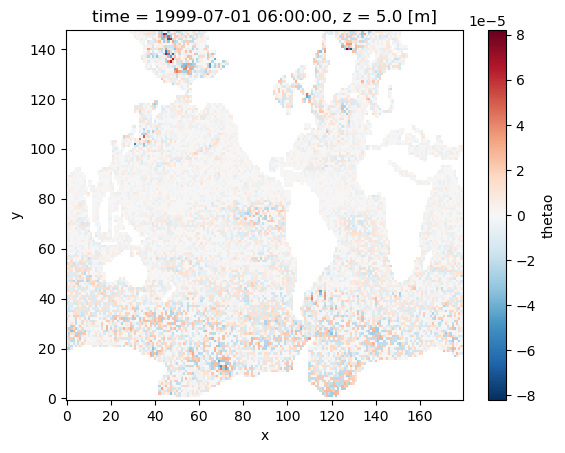

In [31]:
delta = xdata[var].isel(time=-1,z=0)-total[var].isel(z=0)
delta.plot()

In [36]:
df = elements(expname)
rpa = xdata[var].isel(time=-1).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])

Text(0, 0.5, 'T')

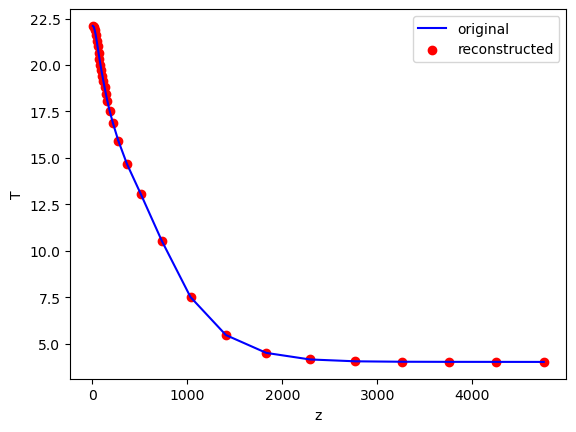

In [41]:
plt.plot(rpa['z'].values,fpa.values, color='b', label='original')
plt.scatter(fpa['z'].values,fpa.values, color='r', label='reconstructed')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T')

Text(0, 0.5, 'T difference')

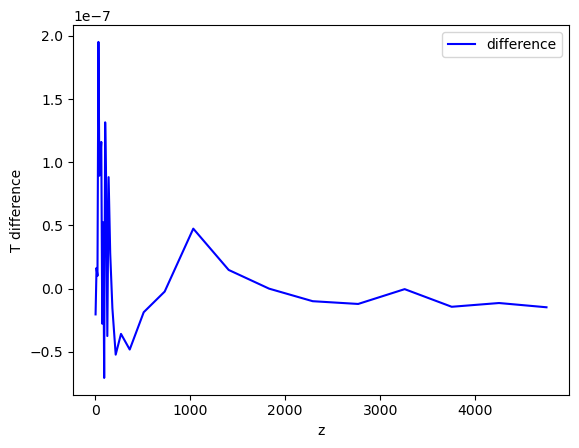

In [42]:
plt.plot(rpa['z'].values,rpa.values-fpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T difference')

In [ ]:
# try the entire procedure and load data from the generated restart files